In [1]:
import os
import pandas as pd
import json
import tensorflow as tf
import numpy as np
import io
from matplotlib import colors
from tensorflow import keras

from azureml.core import Workspace, Dataset
from azureml.core.model import Model

2021-08-13 08:25:20.861725: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def create_mask(img,cats):
    '''creates an mask from image and segmentation categories
    
    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}
    
    Returns:
      A mask of type np.array of dimension (shape(img),len(cats)) '''
    
    
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img=np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)),dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min=min(flat_cat)
    ca_max=max(flat_cat)
    cats_names=list(cats.keys())
    
    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min,ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    return mask


def generate_img_from_mask(mask,cats,colors_palette=['b','g','r','c','m','y','k','w']):
    
    '''Generate a PIL image from a segmented mask and categorie cats with specified color palette for each cateorie
    
    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}
    
    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    for cat in range(len(cats)):
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]
        
    return tf.keras.preprocessing.image.array_to_img(img_seg)  

def normalize_input_img(img):
    '''Normalize PIL image to fall in [-1,1] range, returns 3D numpy array'''
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)
    img = img/127.5
    img -= 1
    return img

def get_concat_h(im1, im2):
    
    '''concatenate two PIL images horizontaly'''
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def show_results(img,mask,model):
    
    '''concatenates the img, the reference mask and the predicted mask'''

    img_norm = np.array(normalize_input_img(img))
    
    img_pred = model.predict(img_norm.reshape(1,128,256,3))[0]
    
    res = get_concat_h(get_concat_h(img,generate_img_from_mask(create_mask(mask,cats),cats)),generate_img_from_mask(img_pred,cats))
    
    return res

In [3]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

oc-p8	westeurope	oc-p8-ressource-group


In [4]:
%%writefile script_folder/echo_score.py

import json

def init():
    print('This is init')

def run(data):
    test = json.loads(data)
    print(f'received data {test}')
    return(f'test is {test}')

Overwriting script_folder/echo_score.py


# Local deployment for test and debug

## Inference config

In [5]:
from azureml.core import Environment
from azureml.core.model import InferenceConfig

env = Environment(name='project_environment')
inf_config = InferenceConfig(environment=env, source_directory='script_folder', entry_script='./echo_score.py')

## Deployment configuration

In [6]:
from azureml.core.webservice import LocalWebservice

deploy_config = LocalWebservice.deploy_configuration(port=6789)

## Local deployment

In [7]:
model = Model(workspace=ws,name='FCN8_final')

In [8]:
from azureml.core.model import Model

service = Model.deploy(ws, "myservice", [model] , inf_config, deploy_config)
service.wait_for_deployment(show_output=True)
print(service.get_logs())

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry 86fbece3485341c6a3c756a0ad684952.azurecr.io
Logging into Docker registry 86fbece3485341c6a3c756a0ad684952.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 86fbece3485341c6a3c756a0ad684952.azurecr.io/azureml/azureml_6dcbe4a6bf560bccfd802db7c65448ba
 ---> 30a18654dec9
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> aaa8276a5e51
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6Ijg3ODE3NTFjLTcwZGQtNDQxYS04YzQ1LTIyNzQyMDg4NTFjMCIsInJlc291cmNlR3JvdXBOYW1lIjoib2MtcDgtcmVzc291cmNlLWdyb3VwIiwiYWNjb3VudE5hbWUiOiJvYy1wOCIsIndvcmtzcGFjZUlkIjoiODZmYmVjZTMtNDg1My00MWM2LWEzYzctNTZhMGFkNjg0OTUyIn0sIm1vZGVscyI6e30sIm1vZGVsc0luZm8iOnt9fQ== | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in 95f1e97a4178
 ---> 6d20f23ba83e
Step 4/5 : RUN mv '/var/azureml-app/tmp1ohhdg18.py' /var/azureml-app/main.py
 ---> Running in 69af551

Error: Container has crashed. Did your init method fail?



WebserviceException: WebserviceException:
	Message: Error: Container has crashed. Did your init method fail?
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Error: Container has crashed. Did your init method fail?"
    }
}

## Test with dummy query

In [32]:
import requests
import json

uri = service.scoring_uri
requests.get('http://localhost:6789')
headers = {'Content-Type': 'application/json'}
data = {"query": "What color is the fox", "context": "The quick brown fox jumped over the lazy dog."}
data = json.dumps(data)
response = requests.post(uri, data=data, headers=headers)
print(response.json())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## Final entry script

In [9]:
%%writefile script_folder/score.py

import os
import pandas as pd
import numpy as np
import json
import io

from tensorflow import keras




from azureml.core.model import Model


import json

def init():
    print('***************This is init************************************')
    global model # variable needs to be global to be used in run()
    model = keras.models.load_model(Model.get_model_path('FCN8_final'))
    print('***************Model loaded************************************')

def run(request):
    #Load data
    print("loading request")

    #deserialized image
    memfile = io.BytesIO()
    memfile.write(json.loads(request).encode('latin-1'))
    memfile.seek(0)
    X = np.load(memfile).reshape(1,128,256,3)
    print(f" the shape of X is {np.shape(X)}")      
    

    #Run inference
    y_pred = model.predict(X)
    #serialize results
    memfile = io.BytesIO()
    np.save(memfile, y_pred)
    memfile.seek(0)
    prediction = json.dumps(memfile.read().decode('latin-1'))
    
    return (prediction)


Overwriting script_folder/score.py


## Custom environment

In [13]:
env = Environment.get(workspace=ws, name='AzureML-TensorFlow-2.2-CPU')
#env = Environment.get(workspace=ws, name='AzureML-tensorflow-2.4-ubuntu18.04-py37-cpu-inference')
curated_clone = env.clone("customize_curated") # clone the environment to customize it


In [25]:
# Install nedded packages (can read from requirements.txt )
python_packages=['Keras==2.4.3','tensorflow==2.3.0','pandas==1.1.5']
for package in python_packages:
    curated_clone.python.conda_dependencies.add_pip_package(package)

## new inference config

In [26]:
inf_config = InferenceConfig(environment=curated_clone, source_directory='./script_folder', entry_script='./score.py')

## deploy Localy

In [21]:
pd.__version__

'1.3.0'

In [28]:
service = Model.deploy(ws, "myservice", [model], inf_config, deploy_config)
service.wait_for_deployment(show_output=True)
print(service.get_logs())

Generating Docker build context.
2021/08/13 08:58:19 Downloading source code...
2021/08/13 08:58:20 Finished downloading source code
2021/08/13 08:58:21 Creating Docker network: acb_default_network, driver: 'bridge'
2021/08/13 08:58:21 Successfully set up Docker network: acb_default_network
2021/08/13 08:58:21 Setting up Docker configuration...
2021/08/13 08:58:22 Successfully set up Docker configuration
2021/08/13 08:58:22 Logging in to registry: 86fbece3485341c6a3c756a0ad684952.azurecr.io
2021/08/13 08:58:23 Successfully logged into 86fbece3485341c6a3c756a0ad684952.azurecr.io
2021/08/13 08:58:23 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/08/13 08:58:23 Scanning for dependencies...
2021/08/13 08:58:24 Successfully scanned dependencies
2021/08/13 08:58:24 Launching container with name: acb_step_0
Sending build context to Docker daemon  66.56kB
Step 1/18 : FROM mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210806.

In [99]:
service.reload()

Container has been successfully cleaned up.
Starting Docker container...
Docker container running.


## Testing (will be part of the FLask app)

In [29]:
test_img_file='frankfurt_000001_013016_leftImg8bit.png'
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
img_norm = np.array(normalize_input_img(img))

In [30]:
# Serialize the input
memfile = io.BytesIO()
np.save(memfile, img_norm)
memfile.seek(0)
request = json.dumps(memfile.read().decode('latin-1'))
# latin-1 maps byte n to unicode code point n

## Query the ACI

In [33]:
uri = service.scoring_uri
headers = {'Content-Type': 'application/json'}
response = requests.post(uri, data=request,headers=headers)
response

<Response [200]>

In [34]:
# Deserialize the response
memfile = io.BytesIO()
memfile.write(json.loads(response.json()).encode('latin-1'))
memfile.seek(0)
response = np.load(memfile)

In [35]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

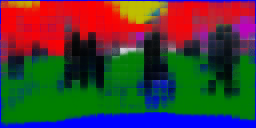

In [36]:
generate_img_from_mask(response[0],cats)

In [37]:
print(service.get_logs())

/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)
2021-08-13T09:09:43,164323287+00:00 - rsyslog/run 
bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by bash)
2021-08-13T09:09:43,166319140+00:00 - gunicorn/run 
2021-08-13T09:09:43,165668223+00:00 - iot-server/run 
2021-08-13T09:09:43,167372468+00:00 - nginx/run 
Dynamic Python package installation is disabled.
Starting HTTP server
EdgeHubConnectionString 

# Deploy in the cloud

In [38]:
from azureml.core.webservice import AciWebservice

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 0.5, memory_gb = 2)

In [39]:
service = Model.deploy(ws, "mywebservice",[model], inference_config=inf_config, deployment_config=deployment_config )
service.wait_for_deployment(show_output=True)
print(service.get_logs())

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-08-13 09:14:46+00:00 Creating Container Registry if not exists.
2021-08-13 09:14:46+00:00 Registering the environment.
2021-08-13 09:14:48+00:00 Use the existing image.
2021-08-13 09:14:48+00:00 Generating deployment configuration.
2021-08-13 09:14:50+00:00 Submitting deployment to compute..
2021-08-13 09:15:23+00:00 Checking the status of deployment mywebservice..
2021-08-13 09:17:50+00:00 Checking the status of inference endpoint mywebservice.
Succeeded
ACI service creation operation finished, operation "Succeeded"
/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)
/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)


In [41]:
from azureml.core import Webservice

service = Webservice(workspace=ws, name='mywebservice')
scoring_uri = service.scoring_uri

In [42]:
scoring_uri

'http://3141efa0-9e82-4d55-bd1f-07f9e7da3d4d.westeurope.azurecontainer.io/score'

In [43]:
service.get_logs()

'/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n/bin/bash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by /bin/bash)\n2021-08-13T09:17:43,523715210+00:00 - rsyslog/run \n2021-08-13T09:17:43,524481206+00:00 - gunicorn/run \nDynamic Python package installation is disabled.\nStarting HTTP server\n2021-08-13T09:17:43,525069102+00:00 - iot-server/run \nbash: /azureml-envs/azureml_19dd65bcd86dcb810b8fda779ddd07f8/lib/libtinfo.so.5: no version information available (required by bash)\n2021-08-13T09:17:43,540062508+00:00 - nginx/run \n/bin/bash: /

In [44]:
import requests
import json

headers = {'Content-Type': 'application/json'}
resp = requests.post(scoring_uri, data=request, headers=headers)

In [45]:
# Deserialize the response
memfile = io.BytesIO()
memfile.write(json.loads(resp.json()).encode('latin-1'))
memfile.seek(0)
resp = np.load(memfile)

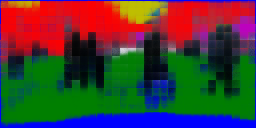

In [46]:
generate_img_from_mask(resp[0],cats)